In [45]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.signal import savgol_filter

In [2]:
os.makedirs('../plots/', exist_ok=True)

pl.style.use('../defaults.mplstyle')

In [3]:
models = ['CESM2', 'CESM2-ground', 'CNRM', 'NorESM', 'E3SM']

In [4]:
df = {}
for model in models:
    df[model] = pd.read_csv(f'../output/{model}.csv', index_col=0, header=[0,1])

In [5]:
df['CNRM'].rename(
    columns={
        "irr_r1i1p1f2": "IRR_01", 
        "irr_r2i1p1f2": "IRR_02", 
        "irr_r3i1p1f2": "IRR_03", 
        "irr_r4i1p1f2": "IRR_04", 
        "irr_r5i1p1f2": "IRR_05", 
        "noirr_r1i1p1f2": "NOI_01", 
        "noirr_r2i1p1f2": "NOI_02", 
        "noirr_r3i1p1f2": "NOI_03", 
        "noirr_r4i1p1f2": "NOI_04", 
        "noirr_r5i1p1f2": "NOI_05", 
    }, inplace=True
)

In [6]:
runids = {}
for model in models:
    runids[model] = []
    for expt in df[model].columns.get_level_values('experiment').unique():
        runids[model].append(expt[-2:])
    runids[model] = list(set(runids[model]))
runids

{'CESM2': ['01', '02', '03'],
 'CESM2-ground': ['01', '02', '03'],
 'CNRM': ['04', '02', '03', '01', '05'],
 'NorESM': ['01', '03'],
 'E3SM': ['01', '02']}

In [7]:
runids

{'CESM2': ['01', '02', '03'],
 'CESM2-ground': ['01', '02', '03'],
 'CNRM': ['04', '02', '03', '01', '05'],
 'NorESM': ['01', '03'],
 'E3SM': ['01', '02']}

In [23]:
erf = {}
for model in runids:
    erf[model] = {}
    if model=='CNRM':
        sw = 'rsut'
        lw = 'rlut'
    else:
        sw = 'rsnt'
        lw = 'rlnt'
    for runid in runids[model]:
        print(model, runid)
        erf[model][runid] = (
            (df[model][f'IRR_{runid}'][sw] - df[model][f'IRR_{runid}'][lw]) - 
            (df[model][f'NOI_{runid}'][sw] - df[model][f'NOI_{runid}'][lw])
        )

CESM2 01
CESM2 02
CESM2 03
CESM2-ground 01
CESM2-ground 02
CESM2-ground 03
CNRM 04
CNRM 02
CNRM 03
CNRM 01
CNRM 05
NorESM 01
NorESM 03
E3SM 01
E3SM 02


In [24]:
colors = {
    'CESM2': 'purple',
    'CESM2-ground': 'red',
    'CNRM': 'green',
    'NorESM': 'blue',
    'E3SM': 'orange'
}

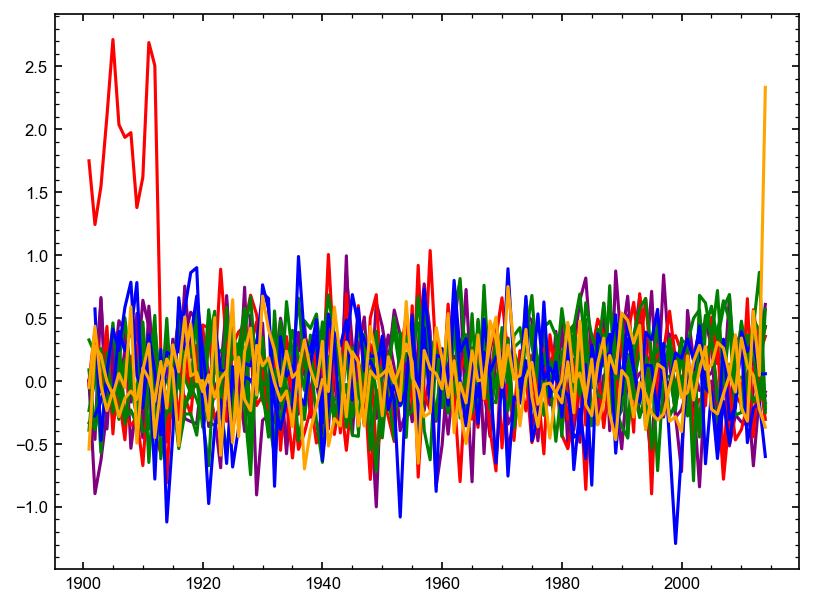

In [25]:
for model in runids:
    for runid in runids[model]:
        pl.plot(erf[model][runid], color=colors[model])

## remove obvious outliers (found by looking at CSV)

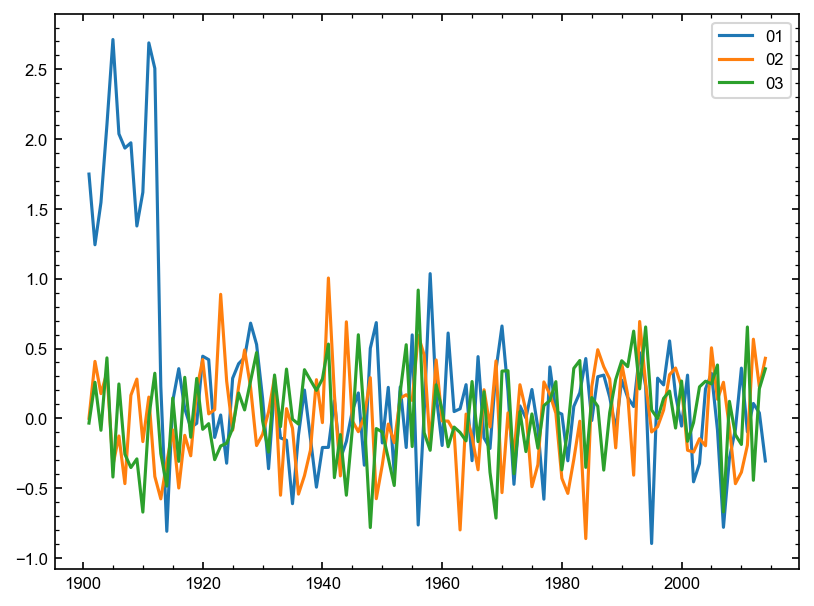

In [27]:
for runid in runids['CESM2-ground']:
    pl.plot(erf['CESM2-ground'][runid], label=runid)
pl.legend()

In [28]:
# 1914 is probably fine, since 1913 is OK we'll leave 1914 in
erf['CESM2-ground']['01'].loc[1901:1920]

1901    1.749925
1902    1.243433
1903    1.546348
1904    2.104201
1905    2.714137
1906    2.037885
1907    1.936127
1908    1.974147
1909    1.377988
1910    1.619651
1911    2.689974
1912    2.507202
1913    0.227848
1914   -0.809585
1915    0.125711
1916    0.355697
1917    0.068599
1918   -0.066206
1919   -0.035981
1920    0.444985
dtype: float64

In [29]:
erf['CESM2-ground']['01'].loc[1901:1912] = np.nan

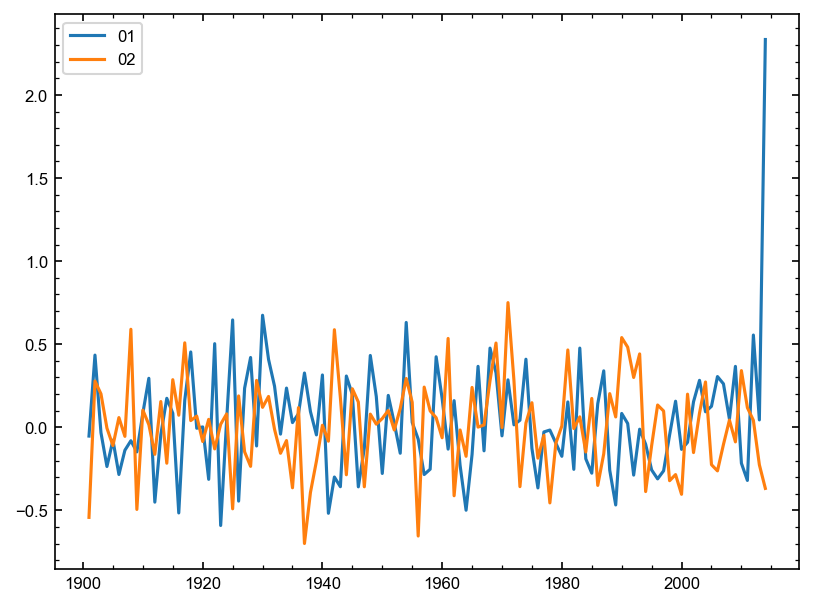

In [30]:
for runid in runids['E3SM']:
    pl.plot(erf['E3SM'][runid], label=runid)
pl.legend()

In [31]:
erf['E3SM']['01'].loc[2014] = np.nan

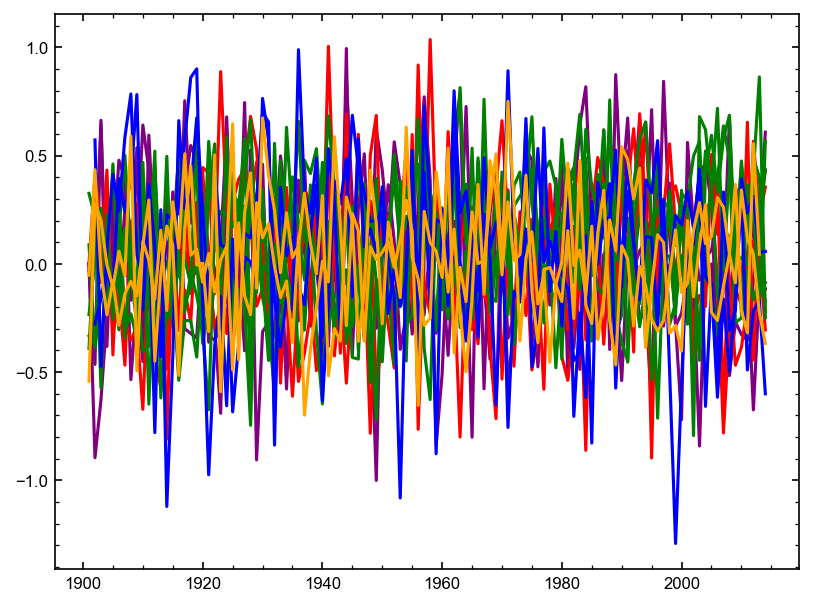

In [32]:
for model in runids:
    for runid in runids[model]:
        pl.plot(erf[model][runid], color=colors[model])

In [43]:
# find the ensemble mean
for model in runids:
    df_mean = pd.DataFrame()
    for runid in runids[model]:
        df_mean = pd.concat((df_mean, erf[model][runid].rename(runid)), axis=1)
    erf[model]['mean'] = df_mean.mean(axis=1)

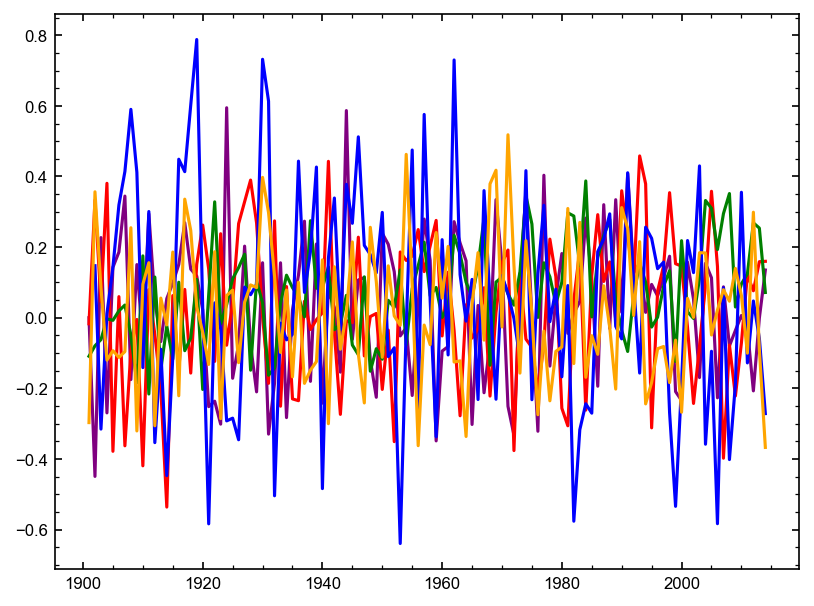

In [53]:
for model in runids:
    pl.plot(erf[model]['mean'], color=colors[model])

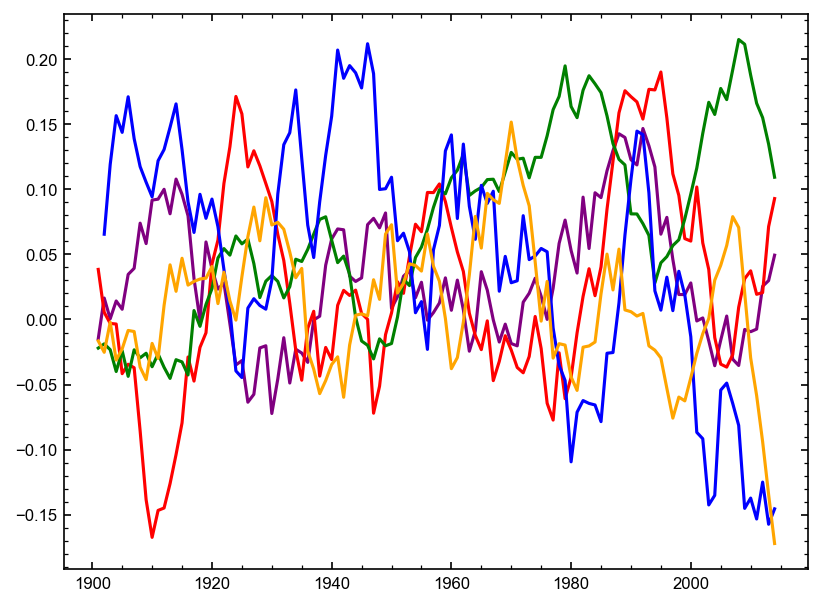

In [51]:
# create an 11-year smoothing filter
for model in models:
    pl.plot(
        erf[model]['mean'].index,
        savgol_filter(np.concatenate((np.zeros(10), erf[model]['mean'], erf[model]['mean'].values[-1]*np.ones(10))), 11, 1)[10:-10],
        color=colors[model]
    )

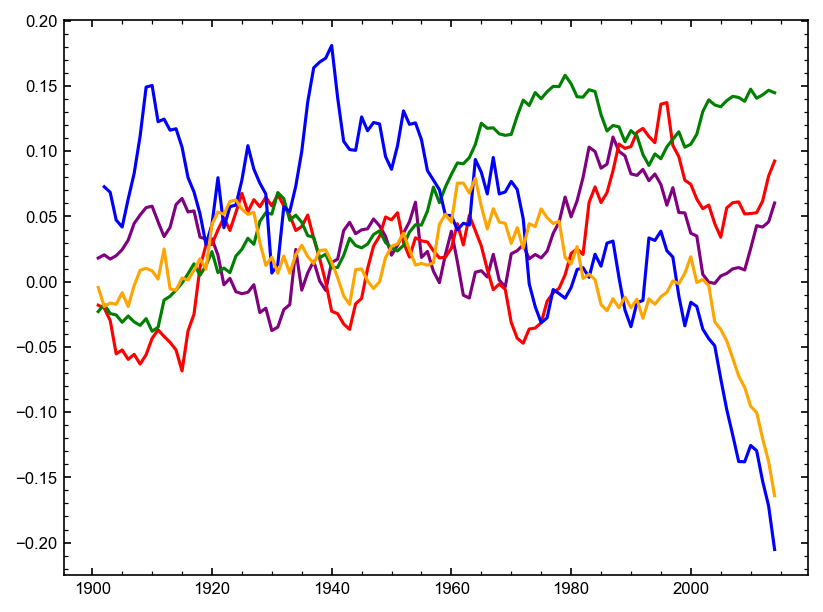

In [52]:
# create a 21-year smoothing filter
for model in models:
    pl.plot(
        erf[model]['mean'].index,
        savgol_filter(np.concatenate((np.zeros(20), erf[model]['mean'], erf[model]['mean'].values[-1]*np.ones(20))), 21, 1)[20:-20],
        color=colors[model]
    )

In [55]:
for model in runids:
    print(model, erf[model]['mean'].mean(), erf[model]['mean'].std())

CESM2 0.027446085087717873 0.20524814639860045
CESM2-ground 0.02497282792397678 0.20989722107057074
CNRM 0.0711305805263157 0.13502161082114855
NorESM 0.04939767876106117 0.31122957407647267
E3SM 0.014955835254324899 0.1941914304275053
